## CIFAR10을 분류하는 CNN Model 만들기

**import package**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

**GPU/CPU setting**


1. 상단메뉴의 런타임 - 런타임 유형 변경 - 하드웨어 가속기 메뉴에서 GPU를 선택 - 저장

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda' :
  torch.cuda.manual_seed_all(777)

cuda


**데이터 불러오기**

CIFAR10 데이터

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform = transforms.ToTensor(), download=True )
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform = transforms.ToTensor(), download=True )

Files already downloaded and verified
Files already downloaded and verified


**데이터를 배치화하기**

In [ ]:
batch_size = 100
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

torch.Size([100])
torch.Size([100, 3, 32, 32])
torch.Size([3, 32, 32])
tensor(9)


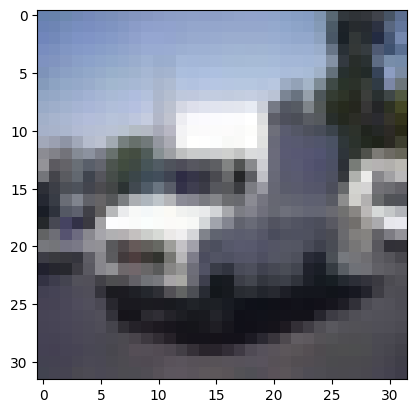

In [ ]:
for i, data in enumerate(train_loader) :
  x,y = data
  print(y.shape)
  print(x.shape)
  print(x[0].shape)
  print(y[0])
  plt.imshow(x[0].permute(1,2,0))
  break

**Convolutional layers 실습**

- nn.Conv2d(input channel개수, output channel개수, 이동간격, 패딩여부)

In [ ]:
conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
conv2 = nn.Conv2d(64,128, kernel_size = 5, stride = 2, padding = 0)
print(conv1)
print(conv2)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))


In [ ]:
# 예제데이터 생성

input_data = torch.Tensor(1,3,32,32)
print(input_data.shape)

torch.Size([1, 3, 32, 32])


In [ ]:
print(conv1(input_data).shape)

torch.Size([1, 64, 32, 32])


In [ ]:
pool = nn.MaxPool2d(2)
print(pool(conv1(input_data)).shape)

torch.Size([1, 64, 16, 16])


In [ ]:
final_output = conv2(pool(conv1(input_data)))
print(final_output.shape)

torch.Size([1, 128, 6, 6])


In [ ]:
final_output = pool(final_output)
print(final_output.shape)

torch.Size([1, 128, 3, 3])


In [ ]:
out = final_output.view(final_output.shape[0], -1)
print(out.shape)

torch.Size([1, 1152])


In [ ]:
# layer간 연결

fc = nn.Linear(1152,10)
fc(out).shape

torch.Size([1, 10])

**CNN Model 생성**

- Activation Function : ReLU

In [ ]:
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()

    self.layer1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(2))
    self.layer2 = nn.Sequential(nn.Conv2d(64,128,kernel_size=5, stride=2, padding=2),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.MaxPool2d(2))

    self.fc = nn.Linear(128*4*4,10)

  def forward(self,x) :
    out = self.layer1(x)
    out = self.layer2(out)

    out = out.view(out.shape[0], -1)
    out = self.fc(out)

    return out


In [ ]:
model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
# 파라미터, 손실함수, 최적화 기법 정의

num_epochs = 10
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Train 과정**

In [ ]:
loss_list = []
for epoch_num in range(num_epochs) :
  average_cost = 0

  for batch_idx, (x_data, y_label) in enumerate(train_loader) :
    num_of_mini_batch = len(train_loader)
    x_data = x_data.to(device)
    input_image = x_data.reshape(batch_size,3,32,32)
    label = y_label.to(device)

    optimizer.zero_grad()
    y_predict = model(input_image)
    loss = criterion(y_predict, label)

    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 1.70873
Epoch 2 Loss 0.98300
Epoch 3 Loss 0.83516
Epoch 4 Loss 0.75052
Epoch 5 Loss 0.67143
Epoch 6 Loss 0.61248
Epoch 7 Loss 0.55423
Epoch 8 Loss 0.50402
Epoch 9 Loss 0.46712
Epoch 10 Loss 0.42040


**Validation 과정**

In [ ]:
with torch.no_grad() :
  num_total_data = 0
  correct = 0
  for batch_idx, (images, labels) in enumerate(test_loader) :

    images = images.reshape(batch_size, 3, 32, 32)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    outputs_softmax = F.softmax(outputs, dim=1)
    predicted = torch.argmax(outputs_softmax, dim=1)

    num_total_data += len(images)
    answer = sum(labels == predicted).item()
    correct += answer

print("Model accuracy {:.5f}%".format((correct/num_total_data)*100))

Model accuracy 72.26000%


## Fine-tuning

**GoogLeNet 모델을 이용하여 파인튜닝하기**

**모델 불러오기**

In [ ]:
model = torchvision.models.googlenet(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 156MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

**모델 재정의하기**

In [ ]:
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

**재학습을 위한 파라미터,손실함수,최적화기법 정의**

In [ ]:
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Train(fine_tuning)과정**

In [ ]:
loss_list = []
for epoch_num in range(num_epochs) :
  average_cost = 0

  for batch_idx, (x_data, y_label) in enumerate(train_loader) :
    num_of_mini_batch = len(train_loader)
    x_data = x_data.to(device)
    input_image = x_data.reshape(batch_size,3,32,32)
    label = y_label.to(device)

    optimizer.zero_grad()
    y_predict = model(input_image)
    loss = criterion(y_predict, label)

    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 0.92326
Epoch 2 Loss 0.59698
Epoch 3 Loss 0.46520
Epoch 4 Loss 0.37059
Epoch 5 Loss 0.30352
Epoch 6 Loss 0.26853
Epoch 7 Loss 0.20214
Epoch 8 Loss 0.17465
Epoch 9 Loss 0.15212
Epoch 10 Loss 0.13782


**Validation 과정**

In [ ]:
with torch.no_grad() :
  num_total_data = 0
  correct = 0
  for batch_idx, (images, labels) in enumerate(test_loader) :

    images = images.reshape(batch_size, 3, 32, 32)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    outputs_softmax = F.softmax(outputs, dim=1)
    predicted = torch.argmax(outputs_softmax, dim=1)

    num_total_data += len(images)
    answer = sum(labels == predicted).item()
    correct += answer

print("Model accuracy {:.5f}%".format((correct/num_total_data)*100))

Model accuracy 82.27000%
